<a href="https://colab.research.google.com/github/always-newbie161/pyprobml/blob/hermissue127/notebooks/clip_imagenette_make_dataset_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook** shows the pipeline to make clip extracted data from Imagenette dataset and stores the data in the form torch.Tensor in a .pt file

To check NVIDIA_GPU devices are available

In [ ]:
!nvidia-smi

Tue Jun 22 17:28:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import and Installations

In [ ]:
!mkdir data
!mkdir notebooks

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘notebooks’: File exists


In [ ]:
cd notebooks

/content/notebooks


In [ ]:
import os
import time
import numpy as np
# seeding makes the CLIP model deterministic.
np.random.seed(0)
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import imageio
import math

Required installations for CLIP:

To know about CLIP,  you may refer to github repo  [CLIP](https://github.com/openai/CLIP) from openai

In [ ]:
# these commands are suggested by CLIP.

! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-36z5k9c8
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-36z5k9c8
  Created wheel for clip: filename=clip-1.0-cp37-none-any.whl size=1368722 sha256=caab03eea332fc55f11ab1751b2e1e061657a6cd221d80287205086d2cb38d24
  Stored in directory: /tmp/pip-ephem-wheel-cache-8jlmnfyd/wheels/79/51/d7/69f91d37121befe21d9c52332e04f592e17d1cabc7319b3e09
Successfully built clip


In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, IterableDataset, get_worker_info

from random import randint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

### Loading the CLIP model
This uses "ViT-B/32" and convertes the data into 512 sized tensors

The CLIP model is jitted and is run on GPU

In [ ]:
import clip
from PIL import Image
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device, jit=True)

In [ ]:
print(model_clip.input_resolution)

tensor(224, device='cuda:0')


## Downloading Imagenette DS 

(run this cell twice, if you are facing an issue while downloading..)



In [ ]:
import tensorflow_datasets as tfds

try:
  data, info = tfds.load("imagenette/160px-v2", with_info=True, as_supervised=True)
except:
  data, info = tfds.load("imagenette/160px-v2", with_info=True, as_supervised=True)
train_data, valid_data = data['train'], data['validation']

### Actual class names for the imagenette v2 dataset

In [ ]:
!wget https://raw.githubusercontent.com/probml/probml-data/main/data/imagenette_class_names.csv

--2021-06-22 17:28:40--  https://raw.githubusercontent.com/probml/probml-data/main/data/imagenette_class_names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168 [text/plain]
Saving to: ‘imagenette_class_names.csv.1’

imagenette_class_na 100%[===================>]     168  --.-KB/s    in 0s      

2021-06-22 17:28:40 (6.01 MB/s) - ‘imagenette_class_names.csv.1’ saved [168/168]



In [ ]:
import csv
csv_reader = csv.reader(open('imagenette_class_names.csv')) 
next(csv_reader) # leaving the first row
class_names = {int(k):v for k,v in csv_reader}
print(class_names)

{0: 'tench_tinca', 1: 'english_springer', 2: 'cassette_player', 3: 'chain_saw', 4: 'church_building', 5: 'french_horn', 6: 'garbage_truck', 7: 'gas_pump', 8: 'golf_ball', 9: 'parachute'}


### Visualizing first N images

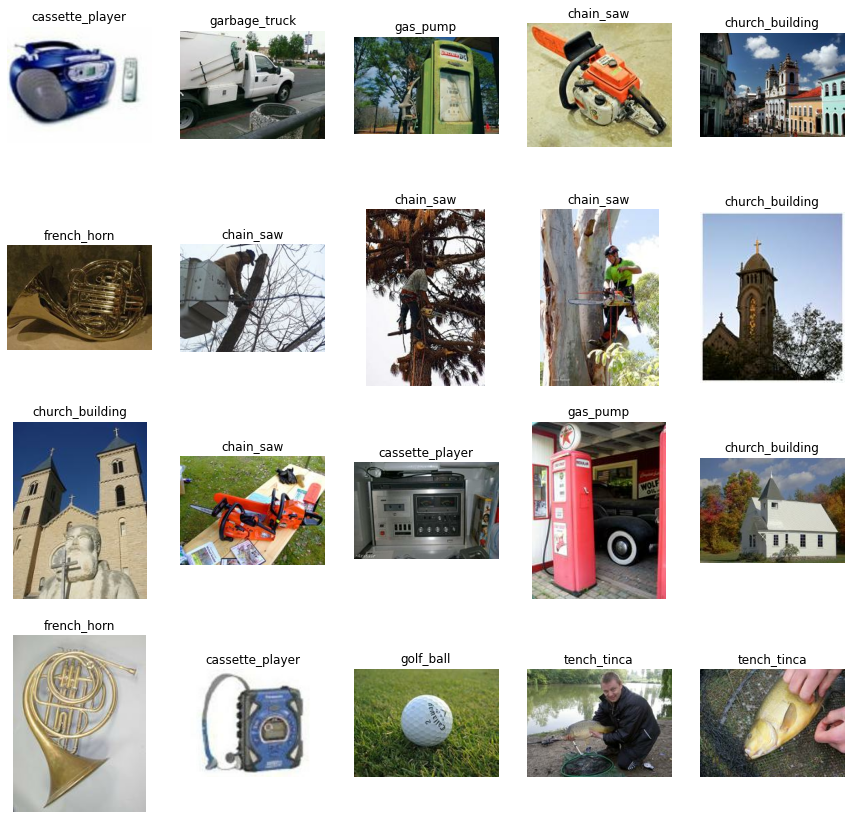

In [ ]:
N = 20
sample_data = list(train_data.take(N).as_numpy_iterator())

fig = plt.figure(figsize=(15,15))

rows = math.floor(math.sqrt(N))
cols = N//rows

for i in range(rows*cols):
  fig.add_subplot(rows,cols,i+1)
  image, label = sample_data[i]
  plt.imshow(image)
  plt.title(class_names[label])
  plt.axis('off')
plt.show()

Cardinality of the Datasets

In [ ]:
print(info.splits['train'].num_examples)
print(info.splits['validation'].num_examples)

9469
3925


## Making the CLIP features


### Dataset class 
which transfroms the data into PIL images which then preprocessed by CLIP's image preprocessor "preprocess_clip"

In [ ]:
class Imagenette_DS(Dataset):

  def __init__(self, data_iter, split):
    self.X = data_iter.repeat(-1).as_numpy_iterator()
    self.split = split

  def __len__(self):
    return info.splits[self.split].num_examples
  
  def __getitem__(self, index):
        image, label = self.X.next()
        image = PIL.Image.fromarray(image)
        sample = (self.transform(image), label)
        return sample
  
  transform=transforms.Compose([
        preprocess_clip
        ])

### Dataloaders 
To make batches which are then encoded by the clip model.

Data should not be shuffled as we are just extracting features (making inference) but not for training.

In [ ]:
batch_size= 128

In [ ]:
imagenette_train_dataset = Imagenette_DS(train_data, 'train')
imagenette_test_dataset = Imagenette_DS(valid_data, 'validation')

*Note: Multiple workers are not used in these dataloaders, as they seem to freeze sometimes* 

*(but you are free to try by setting `num_workers=no.of.cpus` in `DataLoader`, if you are interested check this issue [pytorch-#15808](https://github.com/pytorch/pytorch/issues/15808) )*

In [ ]:
imagenette_train_loader  = DataLoader(
        imagenette_train_dataset, batch_size=batch_size,shuffle=False)

imagenette_test_loader  = DataLoader(
        imagenette_test_dataset, batch_size=batch_size,shuffle=False)

### Encoding the Image data

In [ ]:
import tqdm

In [ ]:
def clip_extract(loader, split, ds_info):
  clip_features = []
  clip_labels = []
  start = time.time()
  with torch.no_grad():
    steps = (ds_info.splits[split].num_examples // batch_size)+1
    for _, batch in zip(tqdm.trange(steps), loader):

      images, labels = batch
      labels = labels.to('cpu')
      images = images.to(device)

      # encoded features are tranferred to cpu right away to decrease the load on cuda memory
      features = model_clip.encode_image(images).to("cpu")
      clip_features.append(features)
      clip_labels.append(labels)

  total = time.time() - start
  print(f"{total:.06}s to compile model")

  clip_features = torch.cat(clip_features)
  clip_labels = torch.cat(clip_labels).unsqueeze(-1)

  print(f'feature_size: {clip_features.shape}')
  print(f'label_size: {clip_labels.shape}')

  clip_train_data = torch.cat((clip_features,  clip_labels), dim=1)

  return clip_train_data


For Training data

In [ ]:
clip_train_data = clip_extract(imagenette_train_loader, 'train', info)

100%|██████████| 74/74 [00:49<00:00,  1.48it/s]

49.9763s to compile model
feature_size: torch.Size([9469, 512])
label_size: torch.Size([9469, 1])


In [ ]:
print(clip_train_data.shape)

torch.Size([9469, 513])


In [ ]:
clip_test_data = clip_extract(imagenette_test_loader, 'validation', info)

100%|██████████| 31/31 [00:19<00:00,  1.62it/s]

19.1542s to compile model
feature_size: torch.Size([3925, 512])
label_size: torch.Size([3925, 1])


In [ ]:
print(clip_test_data.shape)

torch.Size([3925, 513])


## Saving the clip_data

You can download the compressed files for future use

In [ ]:
torch.save(clip_train_data, '/content/data/imagenette_clip_data.pt')
torch.save(clip_test_data, '/content/data/imagenette_test_clip_data.pt')

In [ ]:
!zip /content/data/imagenette_clip_data.pt.zip /content/data/imagenette_clip_data.pt

updating: content/data/imagenette_clip_data.pt (deflated 7%)


In [ ]:
!zip /content/data/imagenette_test_clip_data.pt.zip /content/data/imagenette_test_clip_data.pt

updating: content/data/imagenette_test_clip_data.pt (deflated 7%)


To see demo of the working of these extracted feautures,
you can check out the MLP and logreg examples on clip extracted imagenette data using **Sklearn, Flax(+Jax), Pytorch-lightning!** in the pyprobml repo

## End